In [1]:
import pandas as pd
import numpy as np
import math
from collections import namedtuple

import matplotlib.pyplot as plt

from pathlib import Path
import pickle

"""
CUIDADO!!
"""
import warnings
warnings.filterwarnings("ignore")

In [2]:
from class_pig import pigClass  
from fitterErfClass import funcFitter
from utils import exponential_cicle, find_best_b, plot_exponentials
from collections import namedtuple

In [3]:
"""
Permite não ter que reiniciar o kernel para testar mudanças nos arquivos *.py
"""

%load_ext autoreload
%autoreload 2

### **Settings** 

In [4]:
# função usada para fitar o modelo PV sigmoide (doente)
#                b                                   b
# V(x) = a + ----------------------   = a + ------------------------
#            1 + exp(-(x/d) + (c/d)          1 + exp(-x/d).exp(c/d)
#
# lim (x-> inf)  V(x) = a + b
def sigmoid(x, a, b, c, d):
    return a + b/(1 + np.exp(-(x-c)/d))

# função usada para fitar o modelo PV exponencial (saudável)
def exponential(x, a, b, c, d):
    return a - b*np.exp(-(x-c)/d)

# função usada só para plotar as exponenciais PV a cada passo de pressão
# o primeiro termo depois é fixado (usando função partial())
#
# v(x) = c - a.exp(-bx)   ->   lim (x->inf) v(x) = c
#
def exponential_cicle_fixed_b(best_b, x, a, c):
    return -a*np.exp(-best_b*x)+c

# modelo de unidades recrutadas com erf()
# ajustando a função para uma entrada array (para curve_fit)
def meu_erf_vec(Paw,mi,sigma):
    saida_lst = []
    for x_in in Paw:
        x = (x_in-mi)/(sigma*1.5)
        merf = math.erf(x)
        saida_lst.append((merf/2)+0.5)
    return np.array(saida_lst)

def modelo_sigmoide_erf_vec(Paw,K,Vmax,mi,sigma,offset):
    Vmax_recrutado = Vmax*meu_erf_vec(Paw,mi,sigma)
    V = Vmax_recrutado*(1-np.exp(-K*Paw)) + offset
    return V

# estimadores usados para testar os modelos...
estimators = ["trf", "dogbox"]

model = namedtuple("model",["function","bounds", "inits"])

sigmoid_erf_vec=model(modelo_sigmoide_erf_vec, ([0.02,100,0,2,-600],[0.08,5000,40,40,0]), [0.05, 2000, 10, 10, -200])
model_sigmoid=model(sigmoid, ([-np.inf]*4,[np.inf]*4), [0.05, 2000, 10, 10])

models = [sigmoid_erf_vec]

In [5]:
# verifica quais dados estão disponíveis para análise
for file_name in Path('porquinhos').rglob('*.pickle'):
    print(file_name.name)

porquinho_mra34.pickle
porquinho_mra28.pickle
porquinho_mra31.pickle
porquinho_mra32.pickle
porquinho_mra26.pickle
porquinho_mra29.pickle
porquinho_mra33.pickle


### **Loading and Formating**

In [6]:
"""
lista de dataframe: Cada elemento da lista corresponde a um dataframe de um porco/manobra/passo
"""
dataframes_lst = []

for file_name in Path('porquinhos').rglob('*.pickle'):
    
    #if file_name.name == "porquinho_mra26.pickle": # descomentar para testar só um porquinho
        #print(f"\rRodando {file_name.name}\t\t\t", end="")
        print(f"\rRodando {file_name.name}\t\t\t")
        
        with open(file_name, "rb") as file: # abre o arquivo.pickle

            porquinho = pickle.load(file)
            for manobra in porquinho: #Para cada manobra 

                if manobra == "D": # Posso fazer 3,4,5 passos
                    n_steps = 5
                elif manobra == "C": # Posso fazer 3,4 passos
                    n_steps = 4
                elif manobra == "B": # Posso fazer 3 passos
                    n_steps = 3

                # Formato os dados de entrada
                format_data = []

                for pi, pe, wi, we in zip(porquinho[manobra]["p_i"], porquinho[manobra]["p_e"],
                                          porquinho[manobra]["w_i"], porquinho[manobra]["w_e"]):

                    format_data.extend([pi,wi,pe,we])

                format_data = np.array(format_data).reshape(-1,2) # monta matriz de N linhas e 2 colunas

                ##########################################################

                for n_point in range(3,n_steps+1):
                    fitter = funcFitter(porquinho.name, manobra, format_data, format_data[0::2, :], qtd_steps = n_point, estimators = estimators)
                    dataframes_lst.append(fitter.fit(models=models, interpolate=True, n_interp_point=20, interp_method="linear"))

Rodando porquinho_mra34.pickle			
Rodando porquinho_mra28.pickle			
Rodando porquinho_mra31.pickle			
Rodando porquinho_mra32.pickle			
Rodando porquinho_mra26.pickle			
Rodando porquinho_mra29.pickle			
Rodando porquinho_mra33.pickle			


In [7]:
"""
Pode acontecer de elementos diferentes da listas terem uma quantidade diferente de fits, 
porque não ocorre fit em todos os casos.
"""
n = 4
print(f"O elemento {n} da lista corresponde a essa configuração de porco/manobra/passo.")
dataframes_lst[n].groupby(["subject", "manobra", "qtd_steps"]).count()

O elemento 4 da lista corresponde a essa configuração de porco/manobra/passo.


,,,model,function_name,estimator,error,param,interp_point,interp_pressure,interp_volume,raw_data
subject,manobra,qtd_steps,,,,,,,,,
mra34,D,5,6,6,6,6,6,6,6,6,6


In [8]:
"""
Transforma a lista de dataframes em um único dataframe.
"""

df = pd.concat(dataframes_lst,ignore_index=True)
print(f" A quantidade total de fits realizados foi: {len(df)}.")

 A quantidade total de fits realizados foi: 246.


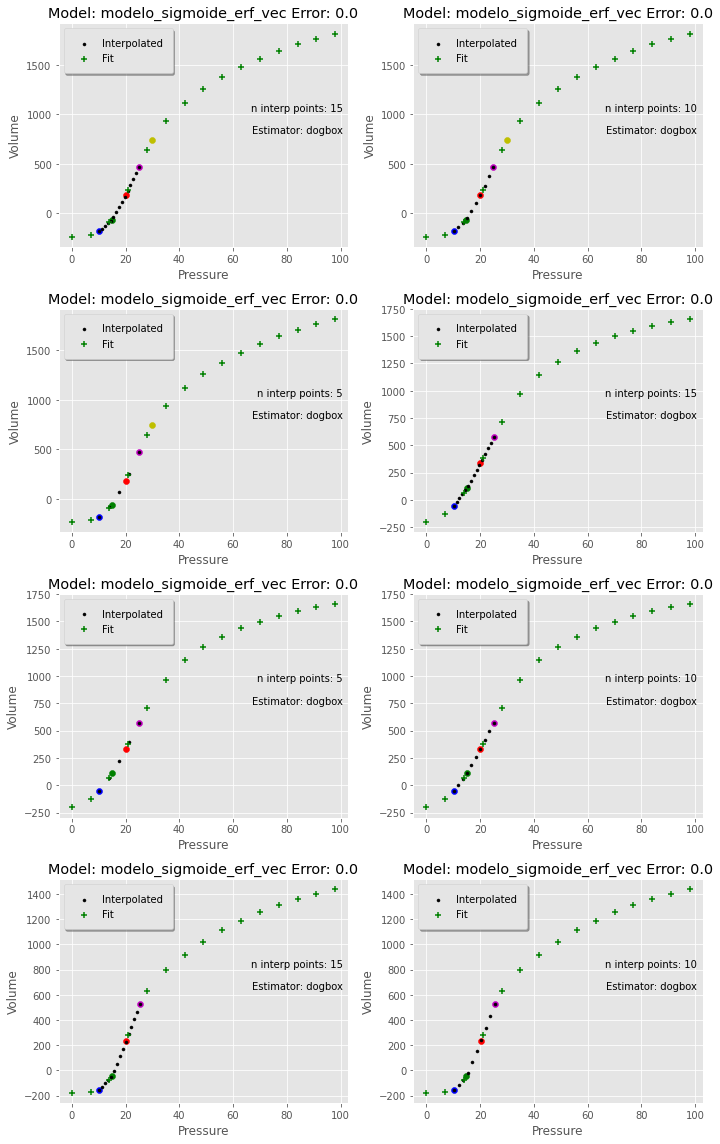

In [9]:
fitter.make_plot(df.query("qtd_steps >= 4").sort_values("error"),8)

In [10]:
raw_data = df.sort_values("error").iloc[23].raw_data
params = df.sort_values("error").iloc[23]["param"]
function = df.sort_values("error").iloc[23]["model"].function

[ 10.62526083 -53.54884338]
[15.39895821 33.33292389]
[ 20.37239647 174.52069092]
[ 25.30625057 308.47189331]
[ 30.62473965 411.90197754]


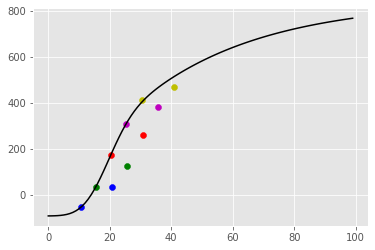

In [11]:
x = np.arange(100)
y=function(x, *params)
colors = ["b","g","r","m","y"]
for fst_run, snd_run, c in zip(raw_data[::2],raw_data[1::2], colors):
    print(fst_run)
    plt.scatter(fst_run[0], fst_run[1], c=c)
    plt.scatter(snd_run[0], snd_run[1], c=c)
plt.plot(y, c='k')

### **Selecting subgroup for analysis** 

In [12]:
# escolhe grupo de teste
def getMinError(x):
    idx = x.error.idxmin()
    return x.loc[idx]
    
if False:
    # pega um subgrupo para teste (manobra D, menores erros gerais)
    df_test = df.query("manobra == 'D'")\
                .sort_values(by = "error")\
                .reset_index(drop=True)\
                .loc[0:5]\
                .copy()
else:
    # pega o melhor fit de cada caso/manobra/n_points
    #df_test = df.groupby(["subject", "manobra", "qtd_steps"])["error"].min().copy()
    #df_test = df.reset_index().groupby(["subject", "manobra", "qtd_steps"],as_index = False)["error"].min()
    df_test=df.groupby(["subject", "manobra", "qtd_steps"]).apply(getMinError).reset_index(drop=True)

### **Checking the function fit** 

In [13]:
# Verificando um exemplo de menor erro
caso = 1
print(df_test.iloc[caso].param)

[ 5.39598990e-02  1.98809955e+03  2.95579194e+01  1.55578442e+01
 -2.47412707e+02]


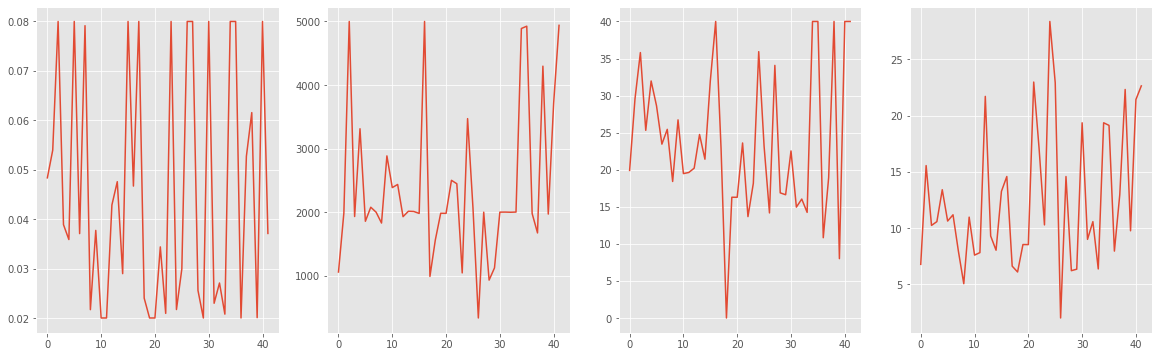

In [14]:
fig, axs = plt.subplots(1,4,figsize = (20,6))

df_test.param.apply(lambda x: x[0]).plot(ax = axs[0])
df_test.param.apply(lambda x: x[1]).plot(ax = axs[1])
df_test.param.apply(lambda x: x[2]).plot(ax = axs[2])
df_test.param.apply(lambda x: x[3]).plot(ax = axs[3])
plt.show()

In [15]:
# b esperado nas exponenciais...
a, b, c, d, offset = df_test.iloc[caso].param
print(f'b estimado para exp com base na sigmoide: {np.exp(c/d)/(b)}')

b estimado para exp com base na sigmoide: 0.0033625286181613928


### **Adding real zero to subgroup** 

In [16]:
# chama a função find_best_b para cada linha do dataframe
df_test[["best_b", "guess_zero"]] = df_test.apply(find_best_b, axis=1, result_type="expand")

In [17]:
idx_min_error = df_test.error.argmin()

opa = df_test.iloc[idx_min_error]

params = opa["param"]

a, b, c, d, _ = params 

b_esperado = np.exp(c/d)/(b)

fit_func  = opa["model"].function

volume_ZEEP_esperado = fit_func(np.array([0]), *params)

### **Creating exponential data** 

876.5453325543465


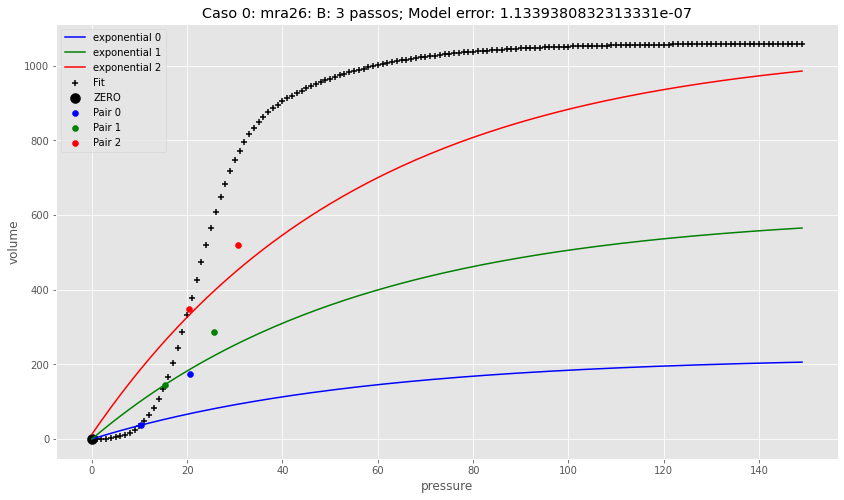

1740.046073032042


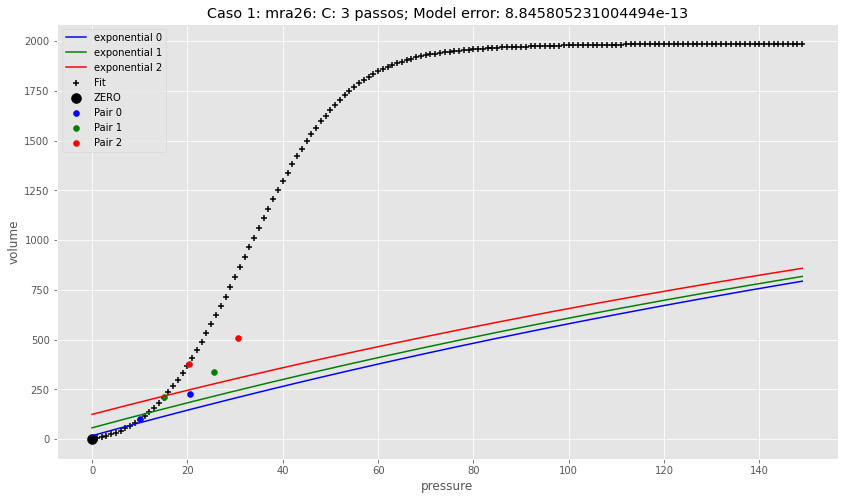

4840.509900417867


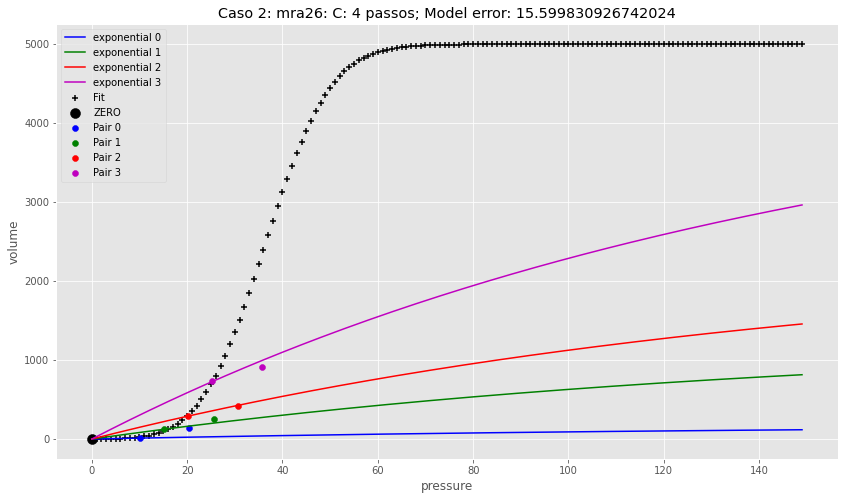

1673.3281882392657


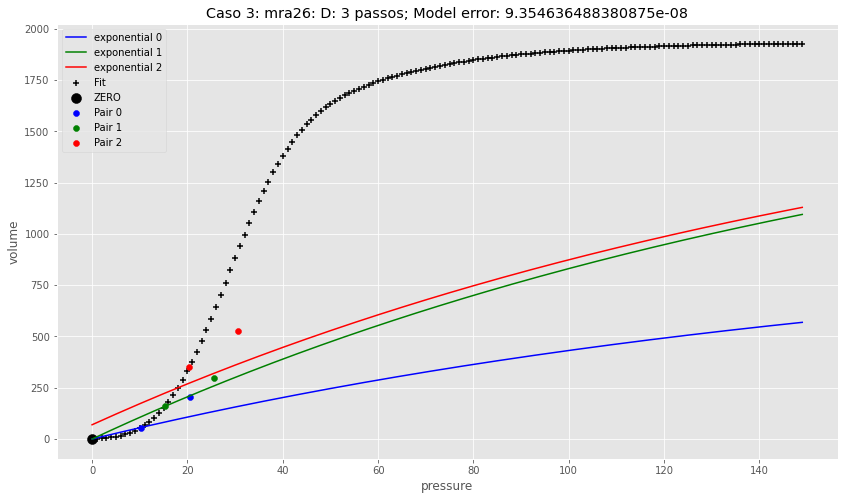

3035.691122877718


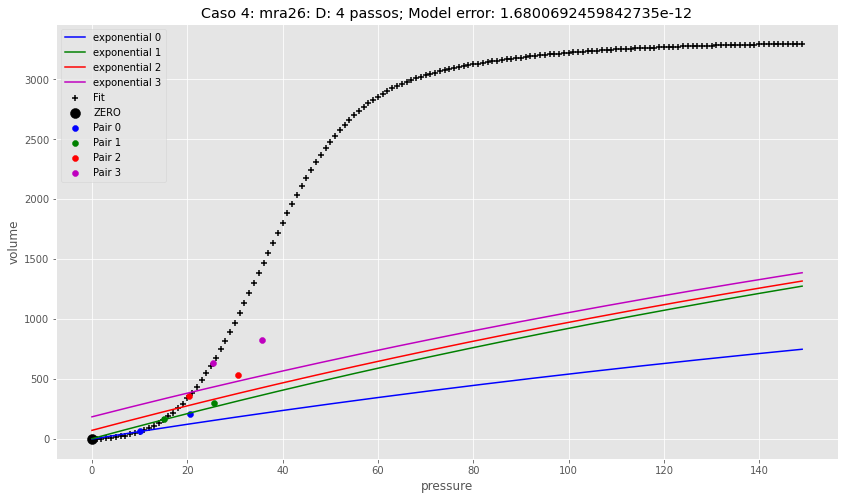

1608.3539964342813


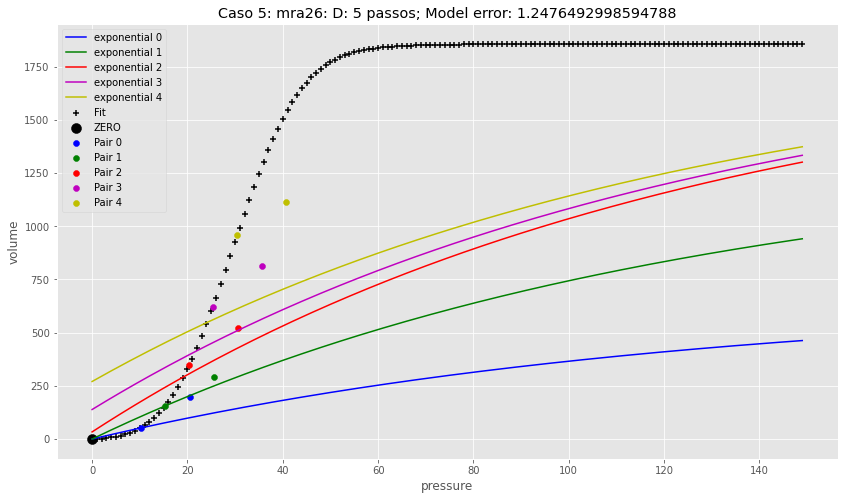

1858.948132711604


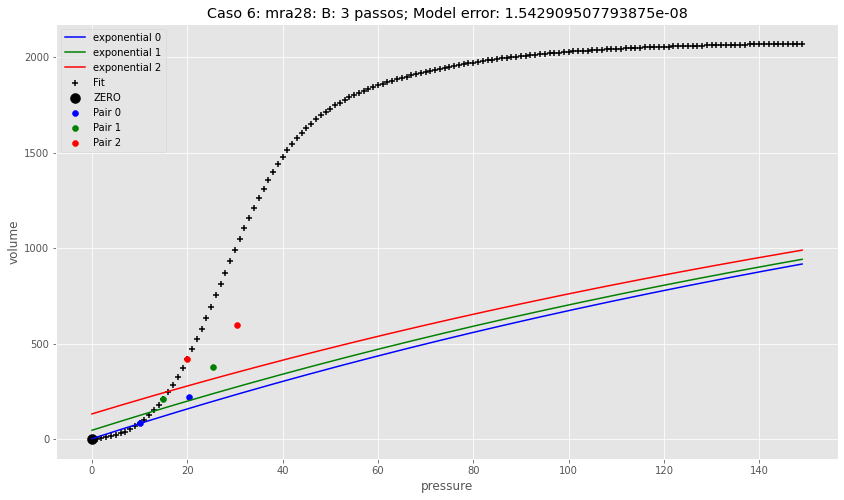

1808.1918916282252


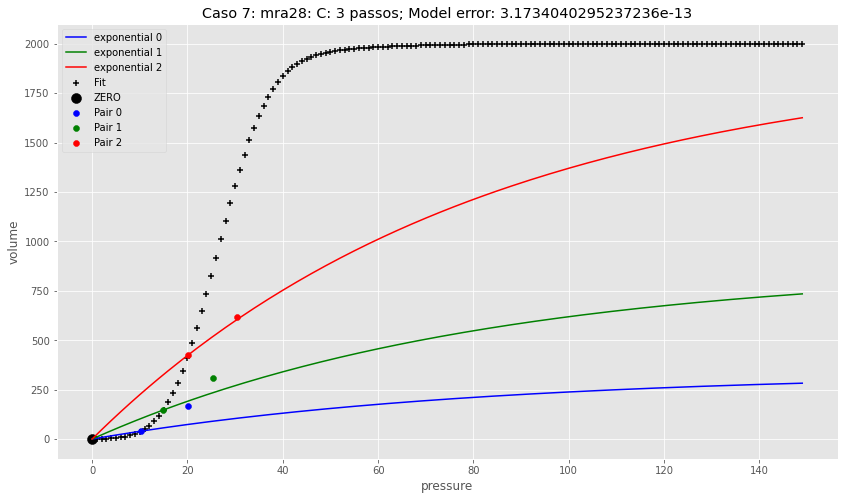

1582.0545053286444


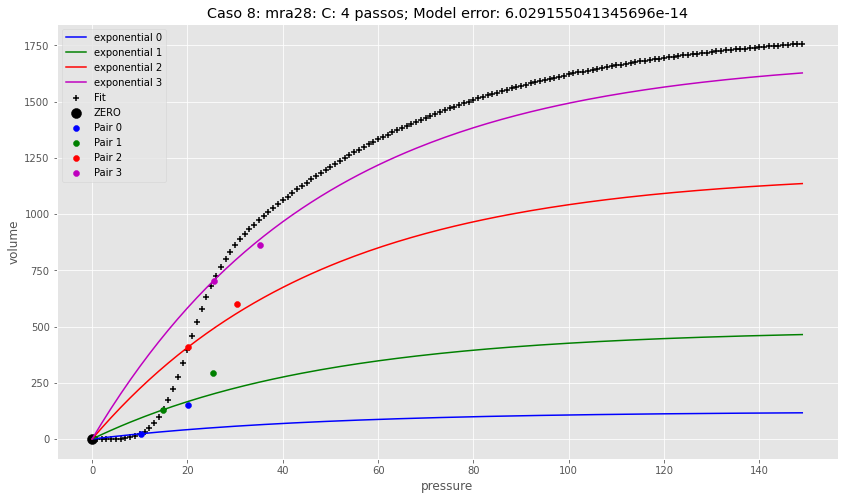

2623.964641546173


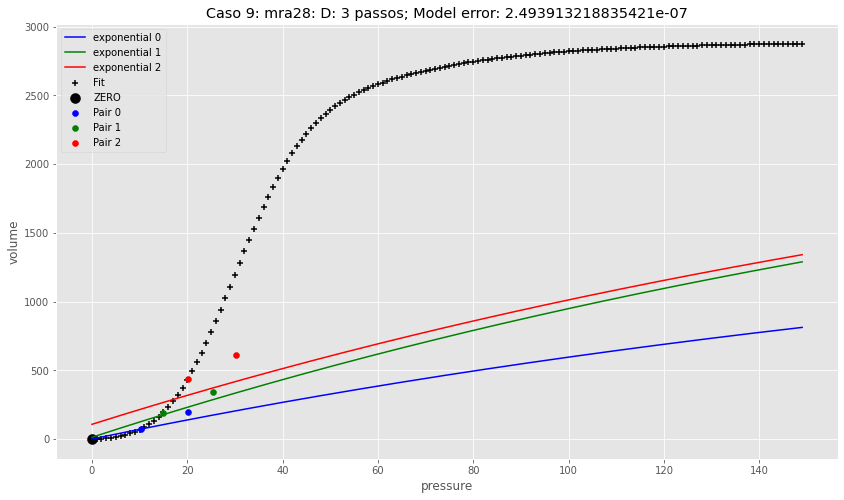

2031.5988565608673


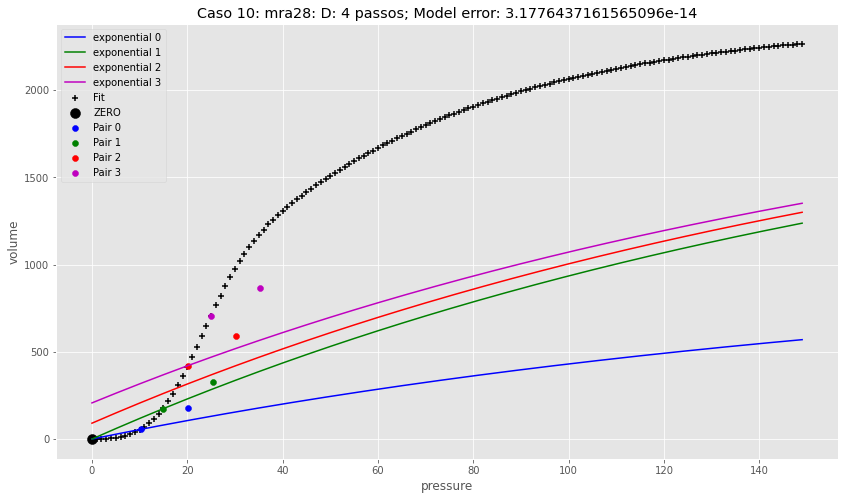

2075.698472604098


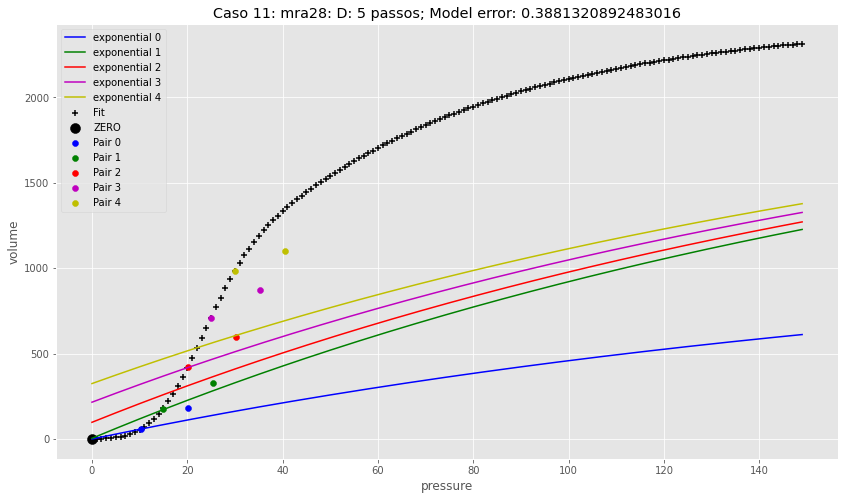

1391.07357046184


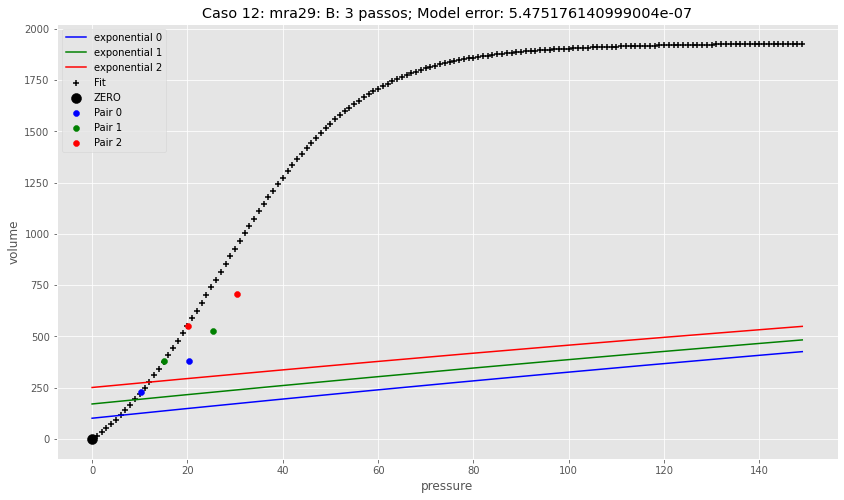

1696.0354907415829


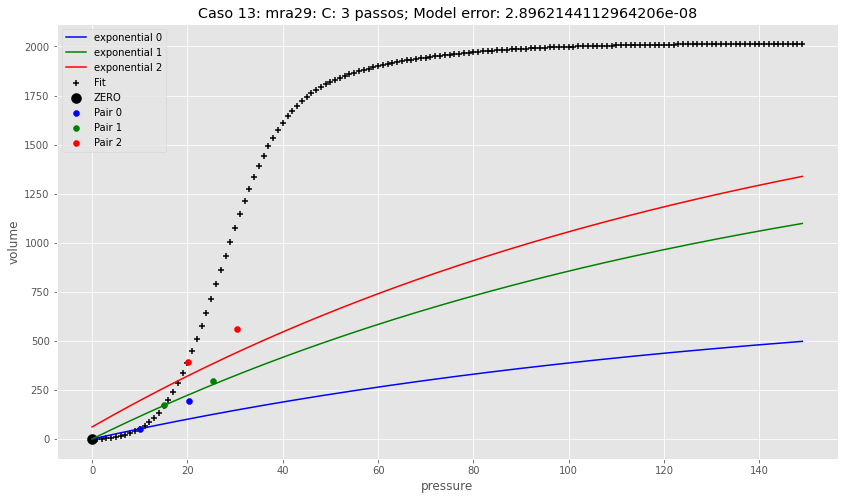

1672.9580663906543


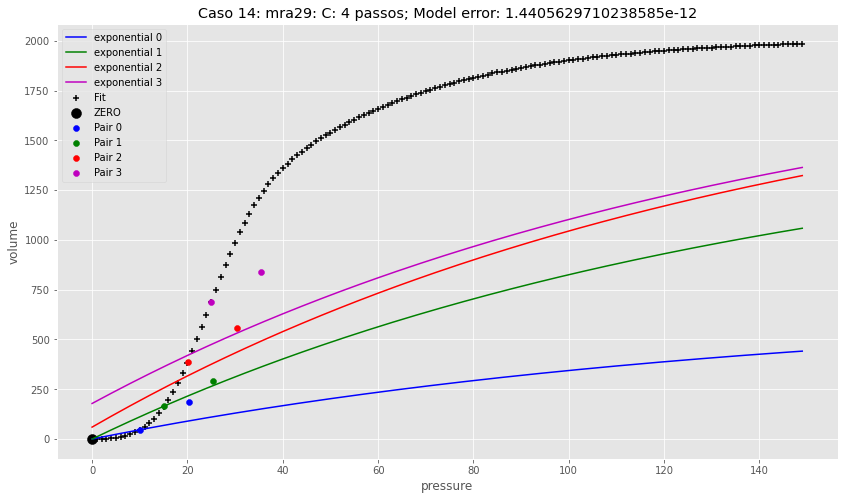

1702.2824116072452


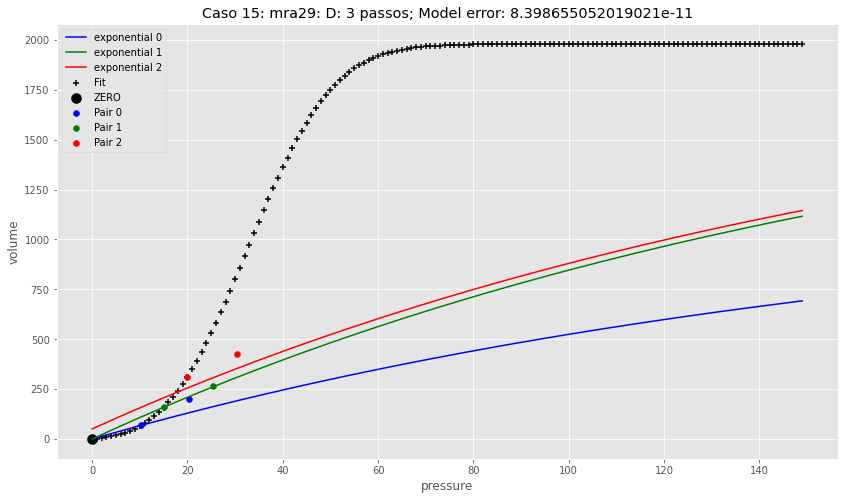

4735.075549188045


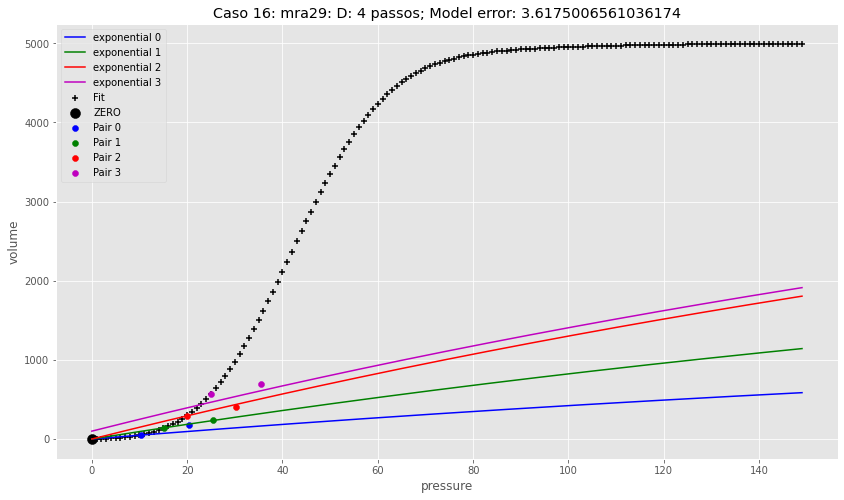

765.747286861492


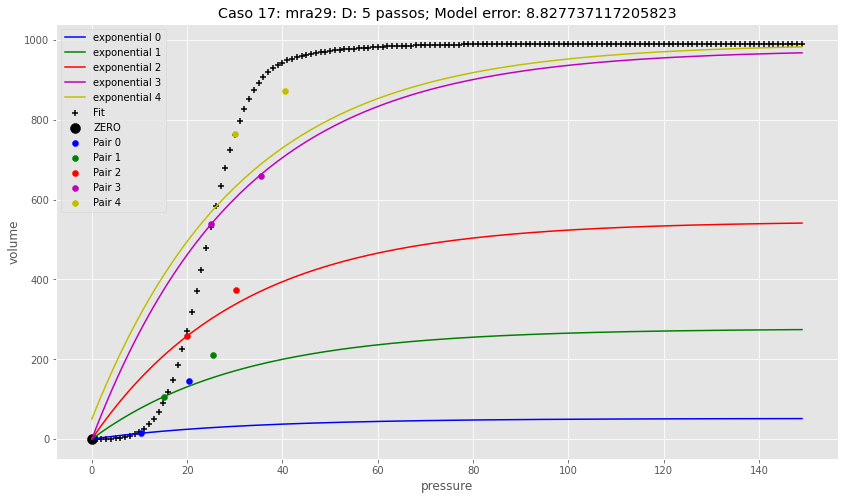

1170.9547040082734


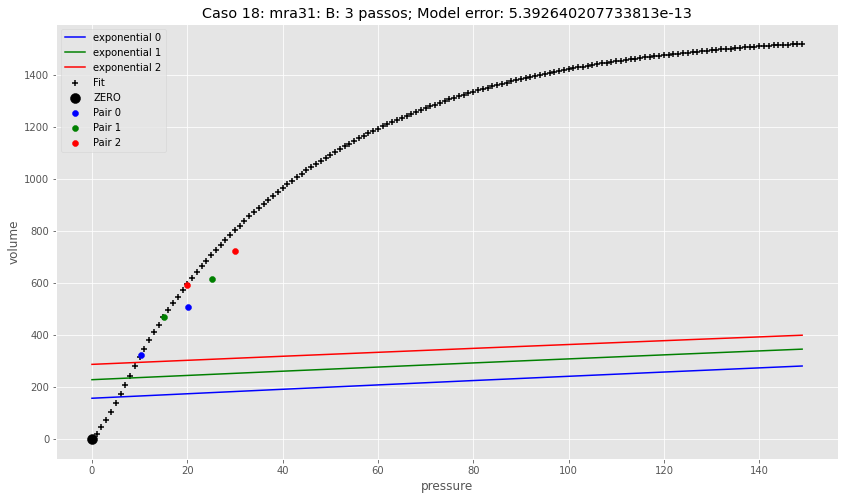

1573.1271746601392


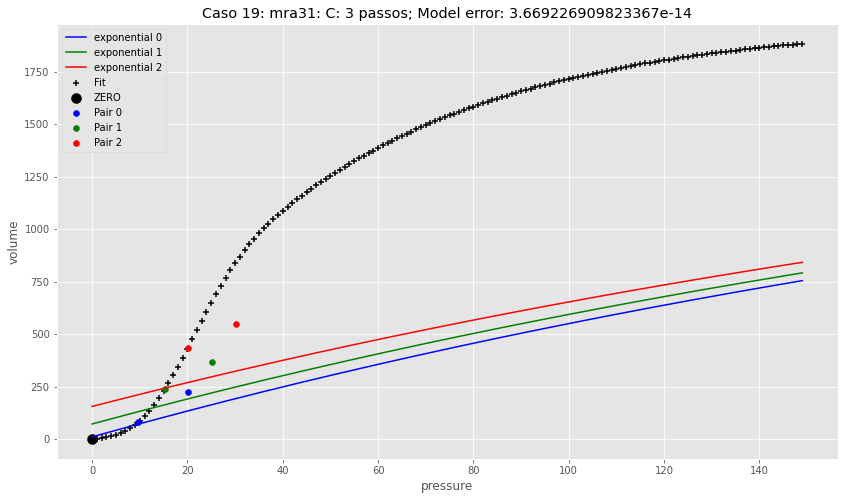

1572.0577136995973


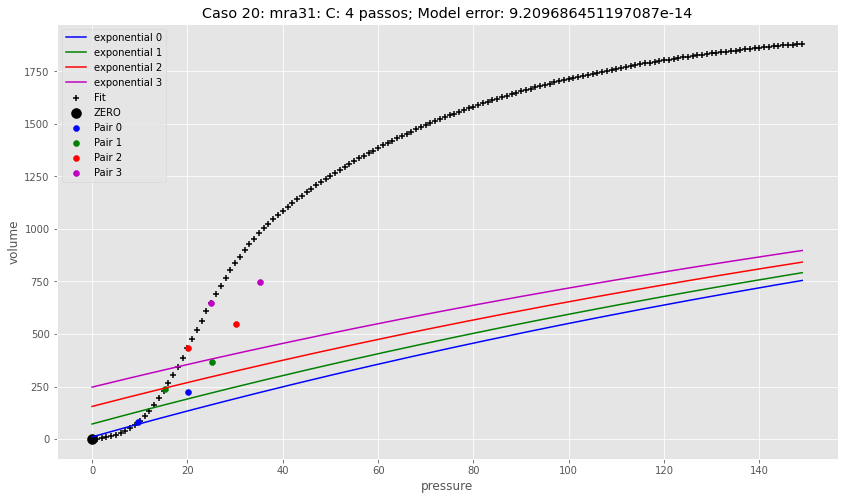

2169.6323837711657


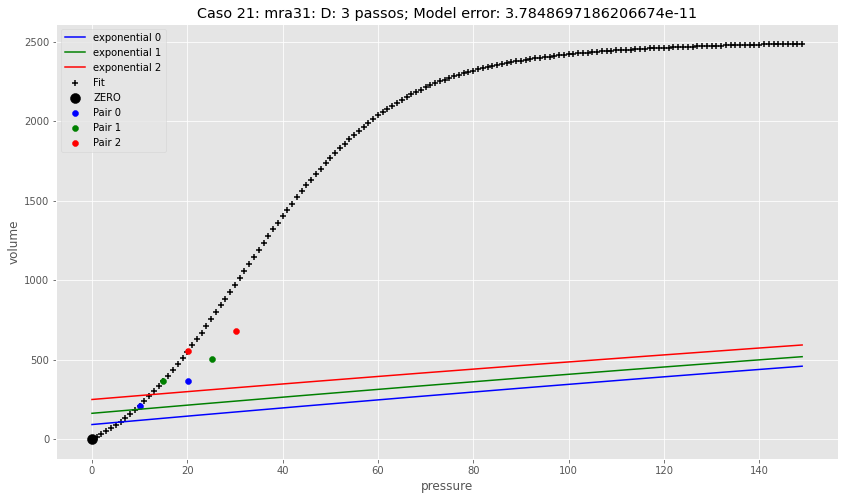

2038.4626837391386


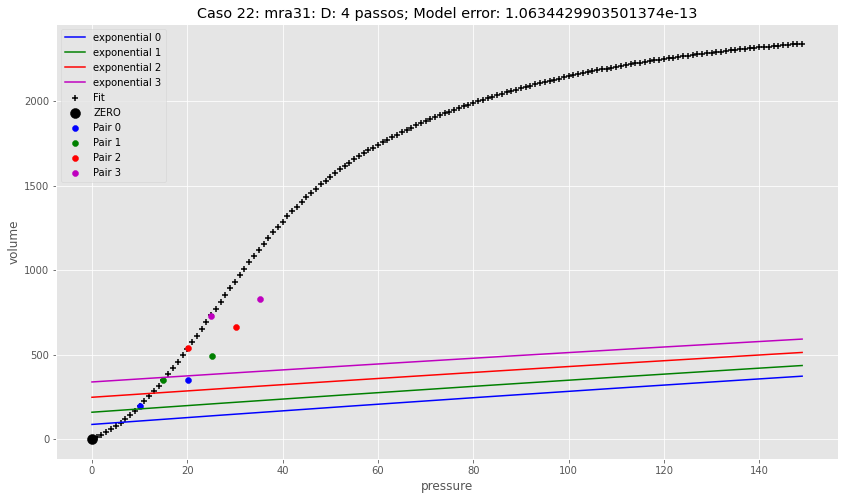

808.590321649974


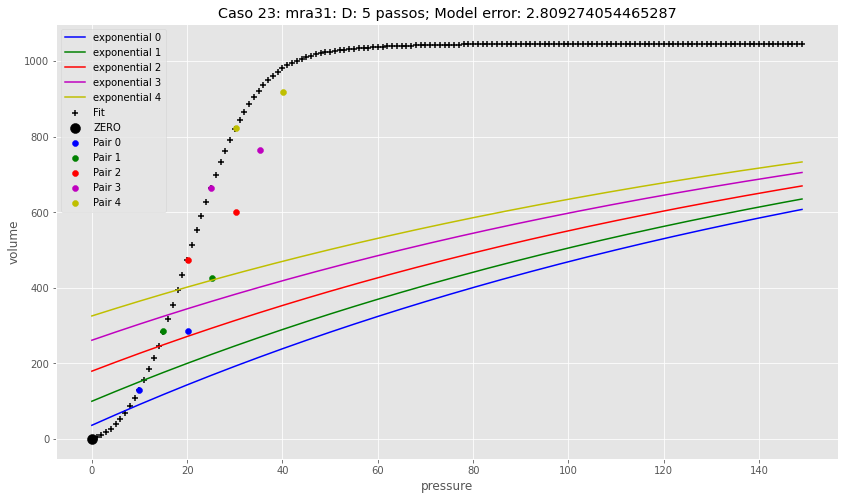

3166.0252947666127


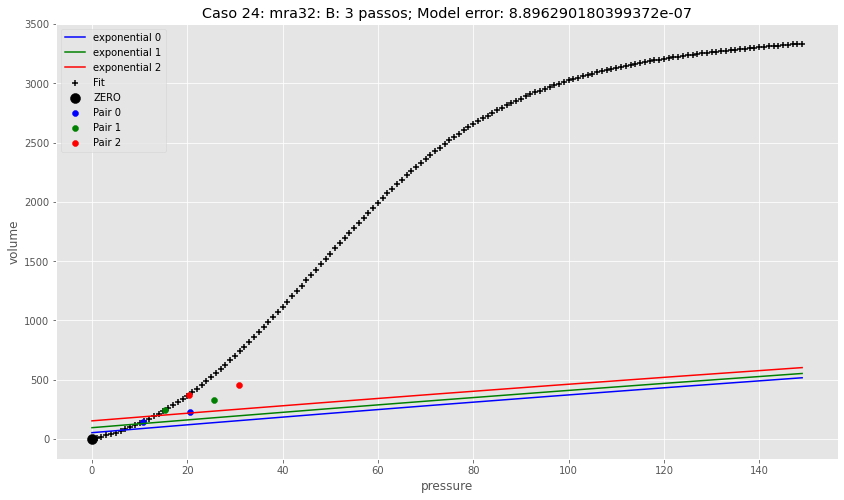

1810.469711216025


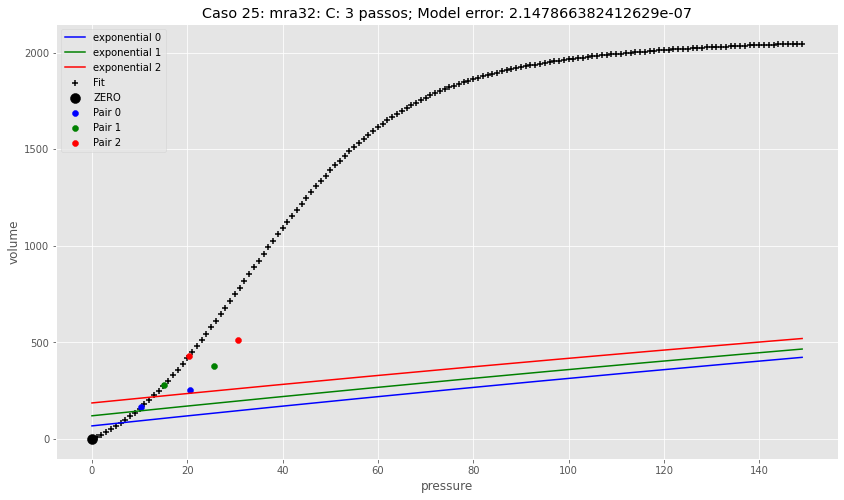

259.6353438434379


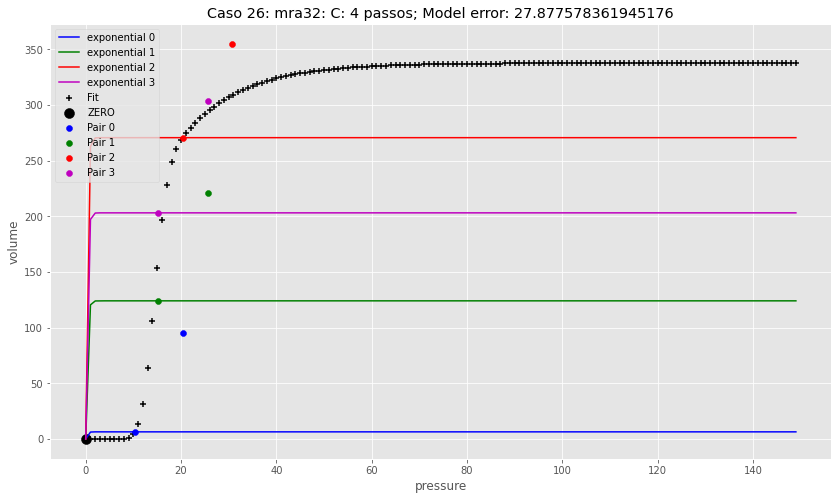

1873.320134027733


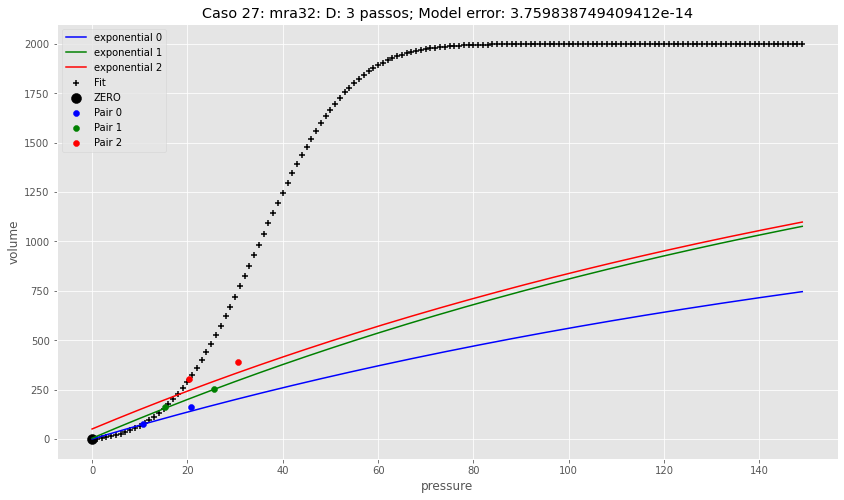

820.8893886601818


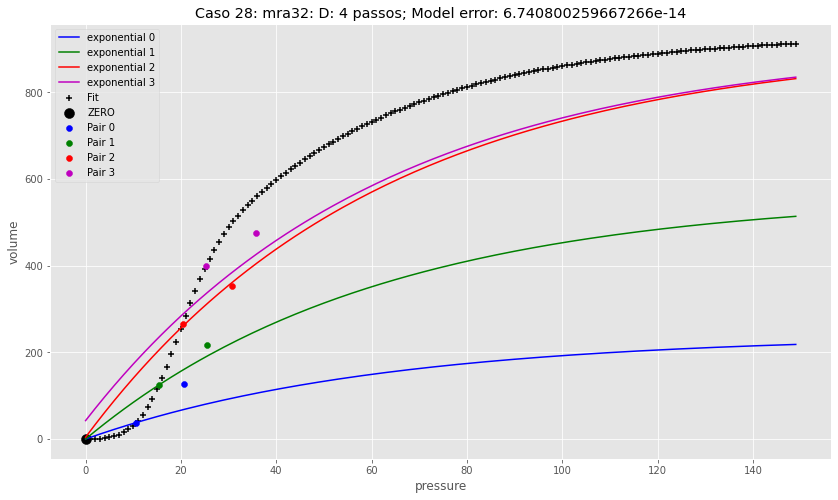

973.7641716567676


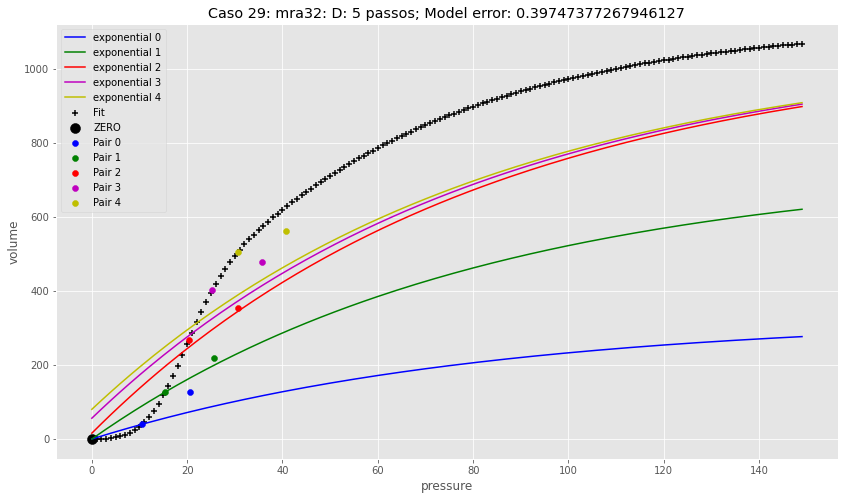

1838.3085517772665


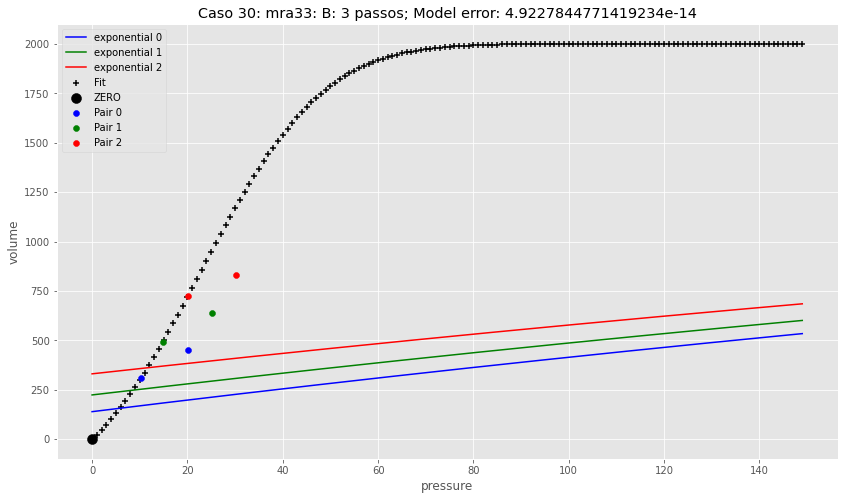

1751.8109553361219


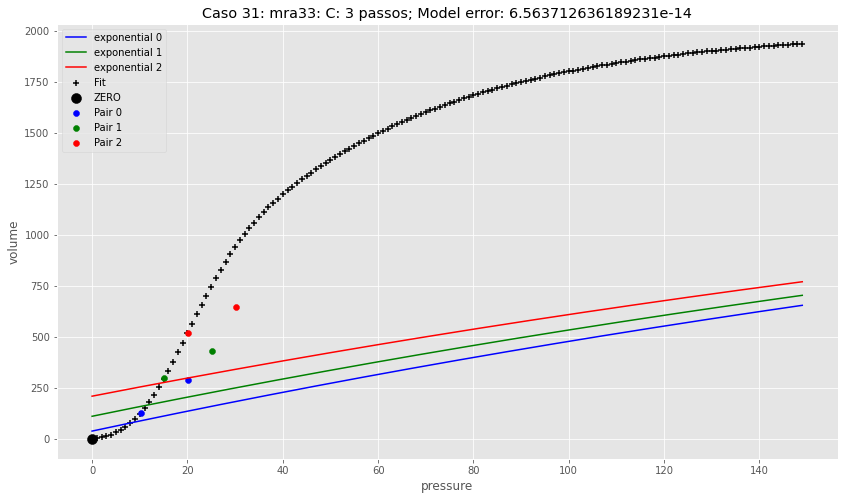

1763.194891159069


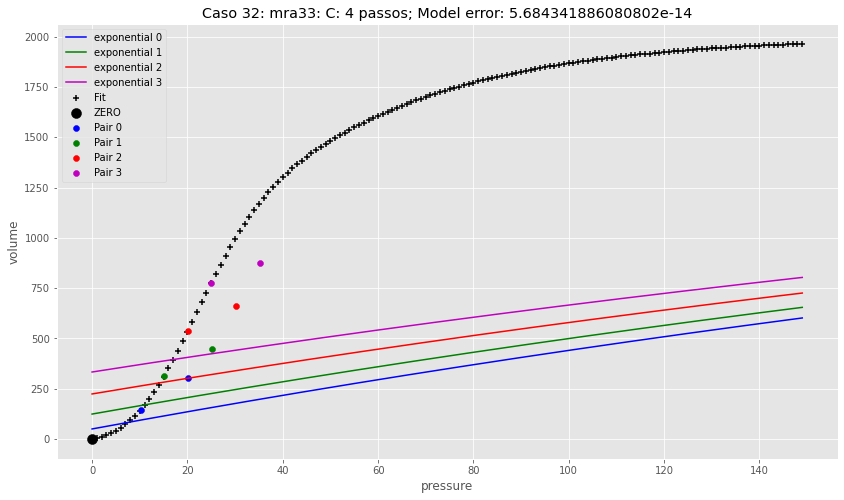

1728.4202980568864


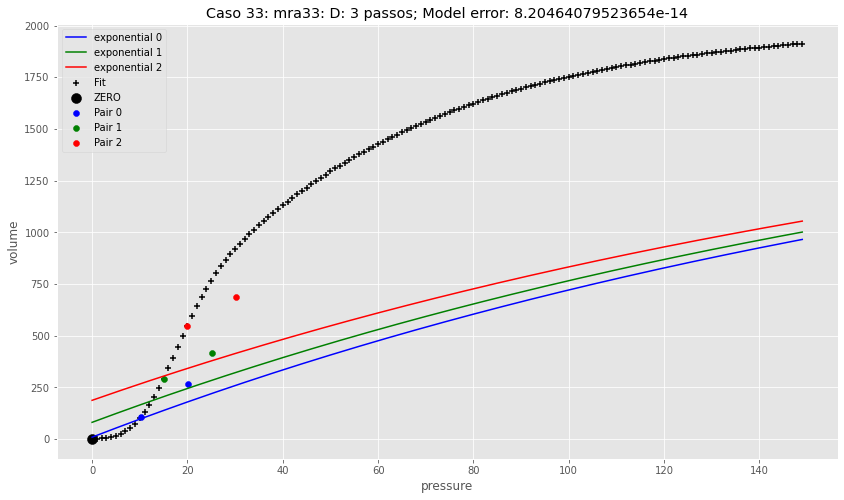

4611.740150387901


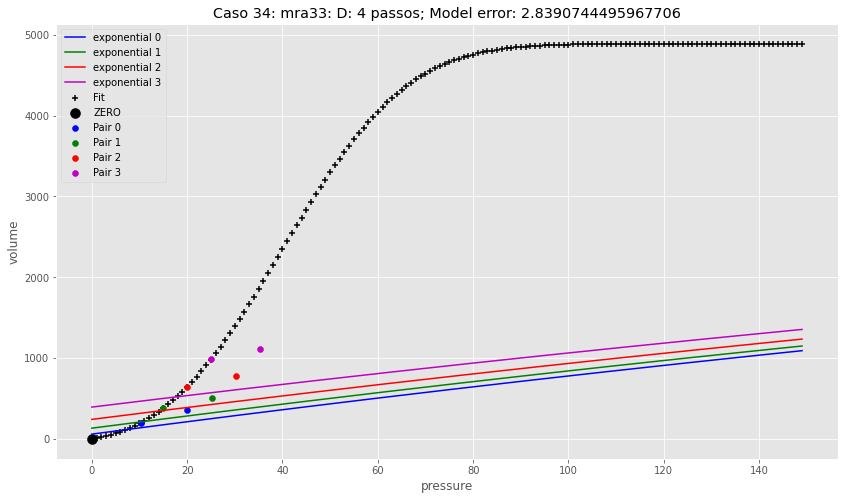

4653.922296939358


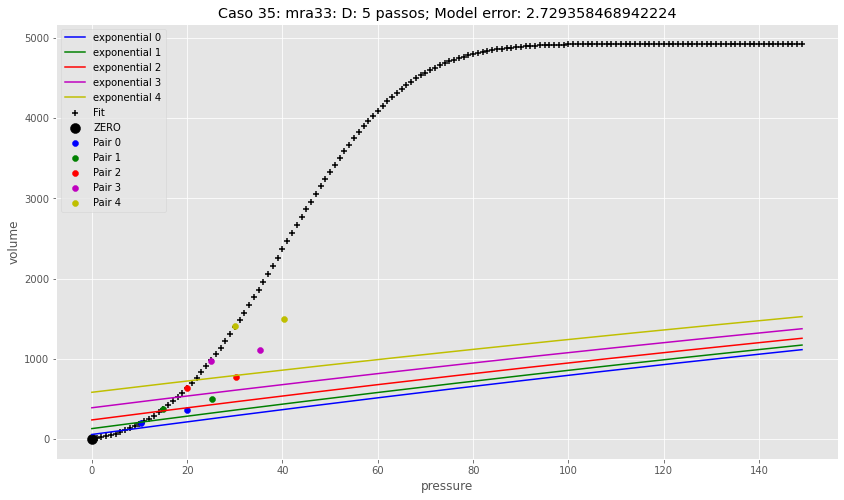

1560.1408713502324


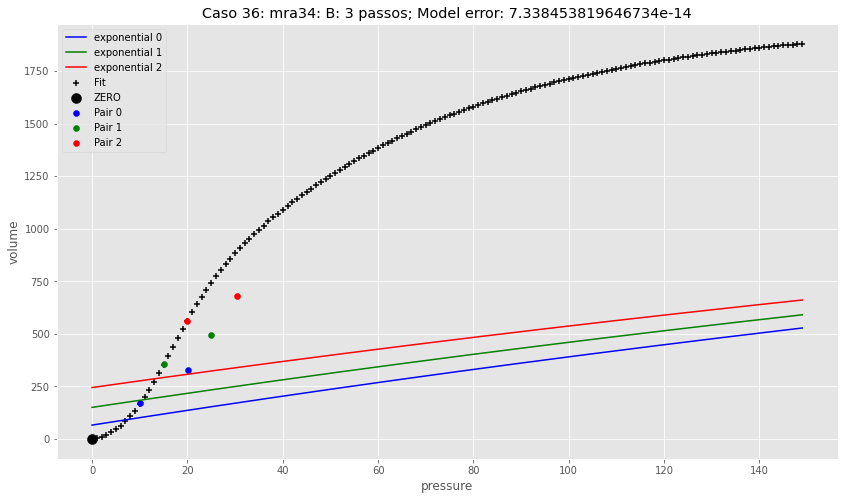

1239.486742919223


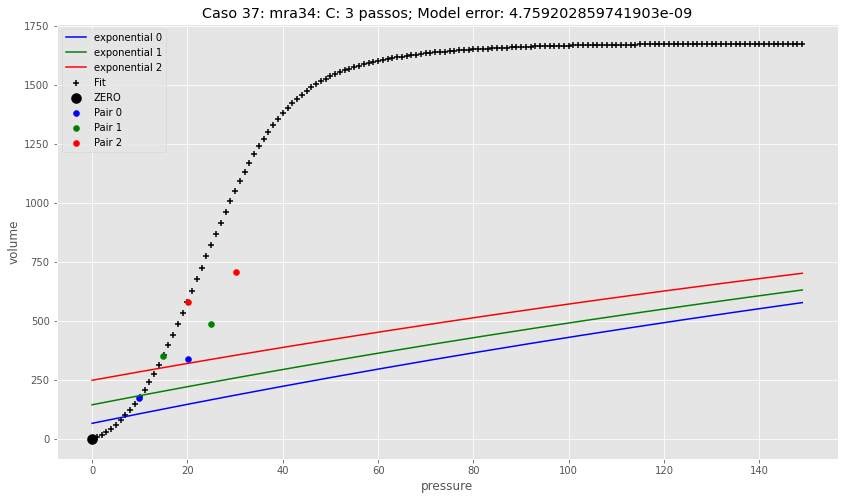

3837.3151017262758


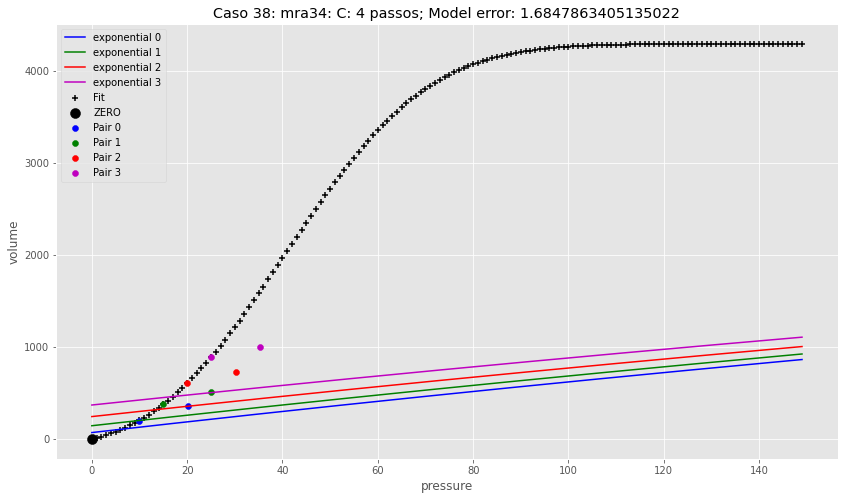

1499.070298844491


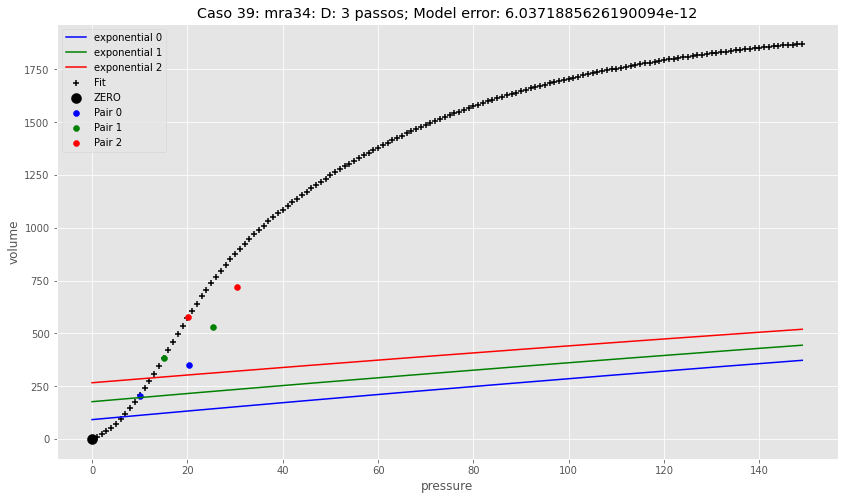

3362.2173572954953


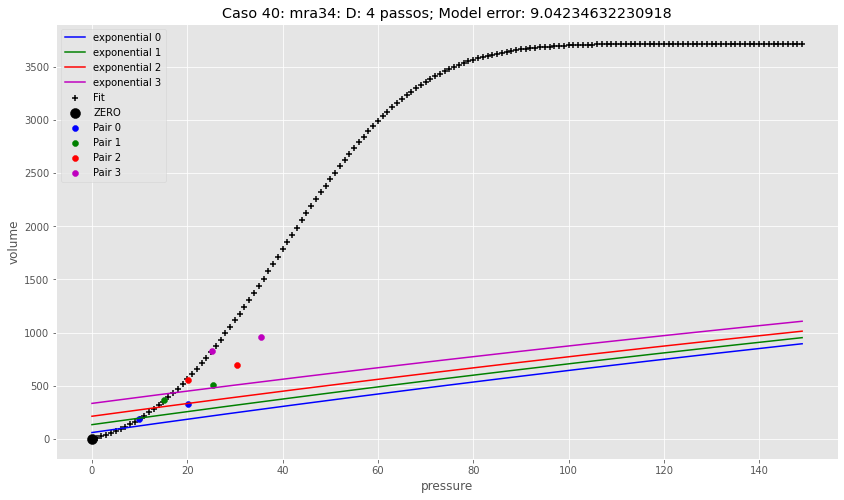

4599.118598499145


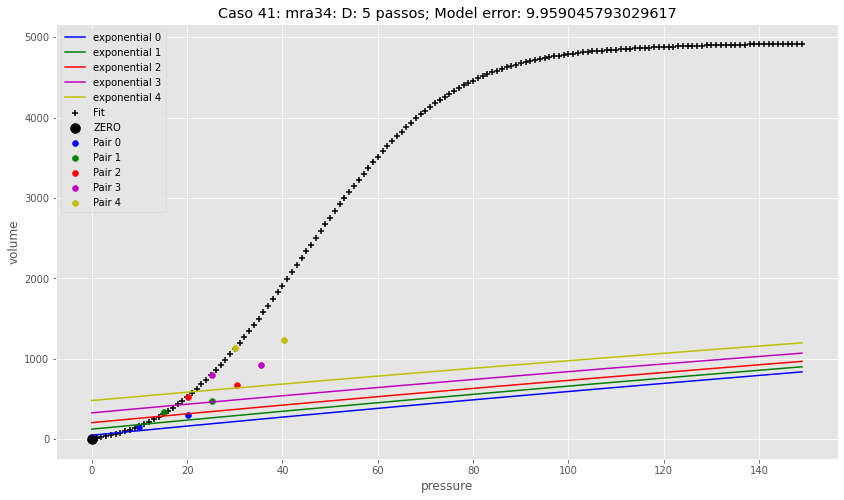

In [18]:
df_test["exponentials"] = df_test.apply(plot_exponentials, args = [exponential_cicle_fixed_b], axis=1)

In [19]:
step     = df_test.iloc[3].qtd_steps
raw_data = df_test.iloc[3].raw_data

raw_data

array([[  10.17812538, -197.85173035],
       [  20.55937481,  -50.39464188],
       [  15.21249962,  -95.13343811],
       [  25.51250076,   41.52325439],
       [  20.421875  ,   97.13526917],
       [  30.65312481,  271.86264038],
       [  25.34687519,  373.07644653],
       [  35.64375114,  563.88049316],
       [  30.46250057,  707.39672852],
       [  40.765625  ,  864.88140869]])

In [20]:
for i in range(2, raw_data.shape[0]+1, 2):

    run = raw_data[i-2:i,:]
    print(run)

[[  10.17812538 -197.85173035]
 [  20.55937481  -50.39464188]]
[[ 15.21249962 -95.13343811]
 [ 25.51250076  41.52325439]]
[[ 20.421875    97.13526917]
 [ 30.65312481 271.86264038]]
[[ 25.34687519 373.07644653]
 [ 35.64375114 563.88049316]]
[[ 30.46250057 707.39672852]
 [ 40.765625   864.88140869]]


In [21]:
for fst_point,snd_point in zip(raw_data[0::2][:step],raw_data[1::2][:step]):
    print()

### **Calculating Volume** 

In [22]:
def get_rec_volume(raw_data, isPlot):
    pass

def get_arp_volume(exponentials, sigmoid_volumes, isPlot):
    arp_lst = []
    max_vol = sigmoid_volumes[-1]
    for exp in exponentials:
        arp_lst.append(max_vol - exp.y[-1])
        
        if isPlot:
            plt.vlines(x=exp.x[-1], ymin=exp.y[-1], ymax=max_vol, lw = 1, colors='k', linestyles = "solid")
            plt.hlines(y=exp.y[-1], xmin=0, xmax=exp.x[-1], lw = 1, colors='k', linestyles = "dashed", alpha = 0.4) 
            plt.hlines(y=max_vol, xmin=0, xmax=exp.x[-1], lw = 1, colors='k', linestyles = "dashed", alpha = 0.4) 
            plt.annotate(r"ARP", xy = (exp.x[-1], max_vol), weight="bold")
            
    return arp_lst

def get_irv_volume(exponentials, snd_raw_data, isPlot):
    
    irv_lst = []
    for exp, snd_raw in zip(exponentials, snd_raw_data):
        
        irv_lst.append(exp.y[-1] - snd_raw[1])
        
        if isPlot:
            plt.vlines(x=exp.x[-1], ymin=snd_raw[1], ymax=exp.y[-1], lw = 1, colors='k', linestyles = "solid")
            plt.hlines(y=snd_raw[1], xmin=snd_raw[0], xmax=exp.x[-1], lw = 1, colors='k', linestyles = "dashed") 
            plt.annotate(r"IRV", xy = (exp.x[-1], exp.y[-1]), weight="bold")
            
    return irv_lst

def get_vt_volume(raw_data, isPlot):
    
    vt_lst = []
    for fst_raw, snd_raw in zip(raw_data[::2], raw_data[1::2]):
        
        x1, y1 = fst_raw
        x2, y2 = snd_raw
        vt_lst.append(y2 - y1)
    
        if isPlot:
            plt.hlines(y=y1, xmin=x1, xmax=x2, lw = 1, colors='k', linestyles = "dashed")
            plt.vlines(x=x2, ymin=y1, ymax=y2, lw = 1, colors='k', linestyles = "solid")
            plt.annotate(r"VT", xy = (x2, y2), weight="bold")
        
    return vt_lst

def get_frc_volume(guess_zero_y, fst_raw_data, isPlot):    
    
    frc_lst = []
    
    for raw_x, raw_y in fst_raw_data:
        
        if isPlot:
            plt.vlines(x=raw_x, ymin=guess_zero_y, ymax=raw_y, lw = 1, colors='k', linestyles = "solid")
            plt.annotate(r"FRC", xy = (raw_x, raw_y), weight="bold")
            
        frc_lst.append(raw_y - guess_zero_y)
    
    return frc_lst

def get_volumes(ser, isPlot):
    
    raw_data        = ser["raw_data"]
    fst_raw_data    = ser["raw_data"][::2]
    snd_raw_data    = ser["raw_data"][1::2]
    guess_zero      = ser["guess_zero"]
    exponentials    = ser["exponentials"]
    
    colors = ["r","m","y","b","g","c"]
    plt.figure(figsize = (20,8))
    
    init_raw_x = raw_data[0][0]
    init_raw_y = raw_data[0][1]
    
    if np.array(list(isPlot.values())).any(): 
        sigmoid_volumes   = ser["function"](exponentials[-1].x, *ser["param"])
        plt.scatter(exponentials[-1].x, sigmoid_volumes, c = "c", marker = "+", label = "Sigmoid")
        for idx, (c, exp, fst_raw, snd_raw) in enumerate(zip(colors, exponentials, raw_data[::2], raw_data[1::2])):
            plt.scatter(fst_raw[0], fst_raw[1], c = c, marker = ".", s = 60)
            plt.scatter(snd_raw[0], snd_raw[1], c = c, marker = ".", s = 60)
            plt.plot(exp.x, exp.y,  c=c, lw=2)
            
    try:
        frc_lst = get_frc_volume(guess_zero[1], fst_raw_data, isPlot["FRC"])
    except:
        frc_lst = []
        
    try:
        vt_lst = get_vt_volume(raw_data, isPlot["VT"])
    except:
        vt_lst = []
    
    try:
        irv_lst = get_irv_volume(exponentials, snd_raw_data, isPlot["IRV"])
    except:
        irv_lst = []
        
    try:
        arp_lst = get_arp_volume(exponentials, sigmoid_volumes, isPlot["ARP"])
    except:
        arp_lst = []
        
    plt.legend()
    plt.show()
    
    return frc_lst, vt_lst, irv_lst, arp_lst


In [25]:
isPlot = {"FRC":True, "VT":True, "IRV": True, "ARP": False}
#df_test[["FRC_V", "VT_V", "IRV_V", "ARP_V"]] = df_test.apply(get_volumes, args = [isPlot], axis =1, result_type = "expand") # NÃO ESTÁ FUNCIONANDO...